# PiCRUST2 Functional Analysis

In [1]:
# Import libraries
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
os.getcwd()


'/Users/camilla.callierotti/ampliseq-visualizations/scripts'

In [2]:
# Set file names
dir = "pipeline-test"
kegg_filename = "KO_pred_metagenome_unstrat_descrip.tsv"
ec_filename = "EC_pred_metagenome_unstrat_descrip.tsv"
metacyc_filename = "METACYC_path_abun_unstrat_descrip.tsv"
meta_filename = "Metadata.tsv"
condition_col = "treatment1"

### KEGG Functional Orthologs

In [3]:
# Load Data
meta = pd.read_csv(f"../input/{dir}/Metadata.tsv", sep="\t")
kegg = pd.read_csv(f"../input/{dir}/picrust/KO_pred_metagenome_unstrat_descrip.tsv", sep="\t", header=0)

In [6]:
# Process KEGG orthology file to create kegg_categories
def parse_kegg_file(filepath):
    with open(filepath, "r") as file:
        kegg_data = file.readlines()
    
    entries = []
    modules = []
    categories = []
    
    module = None
    category = None
    
    for line in kegg_data:

        # Level A - Category (Starts with "A091")
        if line.startswith("A091"):
            category = line[1:].strip() # remove A 
            module = None # reset module when new category starts

        # Level B - Module
        elif line.startswith("B") and category:
            module = line.strip().split("  ", 1)[-1]

        # Level D - Entries
        elif line.startswith("D") and category and module:
            match = re.search(r"K\d{5,6}", line)
            if match:
                entries.append(match.group())
                modules.append(module)
                categories.append(category)
    
    return pd.DataFrame({"Entry": entries, "Module": modules, "Category": categories})

kegg_categories = parse_kegg_file("../input/general/ko00001.keg")
kegg_categories.to_pickle("../intermediate/kegg-categories.pkl")

In [7]:
kegg_categories

,Entry,Module,Category
0,K00844,09101 Carbohydrate metabolism,09100 Metabolism
1,K12407,09101 Carbohydrate metabolism,09100 Metabolism
2,K00845,09101 Carbohydrate metabolism,09100 Metabolism
3,K25026,09101 Carbohydrate metabolism,09100 Metabolism
4,K01810,09101 Carbohydrate metabolism,09100 Metabolism
...,...,...,...
62345,K07220,09194 Poorly characterized,09190 Not Included in Pathway or Brite
62346,K07276,09194 Poorly characterized,09190 Not Included in Pathway or Brite
62347,K07338,09194 Poorly characterized,09190 Not Included in Pathway or Brite
62348,K07586,09194 Poorly characterized,09190 Not Included in Pathway or Brite


In [8]:
# Convert kegg data to long format
value_columns = [col for col in kegg.columns if col not in ["function", "description"]]  # Get all columns that are not function or description
kegg_long = kegg.melt(id_vars=["function"], value_vars=value_columns, var_name="Sample", value_name="Abundance")  # Convert to long format
kegg_long = kegg_long.merge(kegg_categories, left_on="function", right_on="Entry", how="left")  # Add KEGG category to dataframe
kegg_long = kegg_long.merge(meta[["ID", "treatment1"]], left_on="Sample", right_on="ID", how="left").drop(columns=["ID"])  # Add treatment to dataframe
kegg_long["treatment1"] = kegg_long["treatment1"].astype("category")  # Convert treatment to categorical variable

In [9]:
kegg_long

,function,Sample,Abundance,Entry,Module,Category,treatment1
0,K00001,sampleID_1,134.50,K00001,09101 Carbohydrate metabolism,09100 Metabolism,b
1,K00001,sampleID_1,134.50,K00001,09101 Carbohydrate metabolism,09100 Metabolism,b
2,K00001,sampleID_1,134.50,K00001,09103 Lipid metabolism,09100 Metabolism,b
3,K00001,sampleID_1,134.50,K00001,09105 Amino acid metabolism,09100 Metabolism,b
4,K00001,sampleID_1,134.50,K00001,09108 Metabolism of cofactors and vitamins,09100 Metabolism,b
...,...,...,...,...,...,...,...
26707,K19736,sampleID_2a,12.80,K19736,09182 Protein families: genetic information pr...,09180 Brite Hierarchies,a
26708,K19744,sampleID_2a,12.80,K19744,09106 Metabolism of other amino acids,09100 Metabolism,a
26709,K19745,sampleID_2a,39.05,K19745,09101 Carbohydrate metabolism,09100 Metabolism,a
26710,K19746,sampleID_2a,25.60,K19746,09106 Metabolism of other amino acids,09100 Metabolism,a


In [10]:
kegg_long[kegg_long["Category"].isna()]

,function,Sample,Abundance,Entry,Module,Category,treatment1
74,K00050,sampleID_1,411.20,NaN,NaN,NaN,b
446,K00356,sampleID_1,307.00,NaN,NaN,NaN,b
1489,K01572,sampleID_1,4.00,NaN,NaN,NaN,b
2554,K02428,sampleID_1,494.95,NaN,NaN,NaN,b
4085,K05962,sampleID_1,248.00,NaN,NaN,NaN,b
4355,K06955,sampleID_1,115.20,NaN,NaN,NaN,b
4395,K07011,sampleID_1,232.20,NaN,NaN,NaN,b
4445,K07088,sampleID_1,1089.45,NaN,NaN,NaN,b
4551,K07239,sampleID_1,248.00,NaN,NaN,NaN,b
5553,K11189,sampleID_1,468.60,NaN,NaN,NaN,b


In [11]:
# Category-Group dataframe
kegg_transcoding = kegg_long[["Category", "Module", "Entry"]].drop_duplicates().sort_values(by="Category")

In [12]:
kegg_transcoding

,Category,Module,Entry
0,09100 Metabolism,09101 Carbohydrate metabolism,K00001
1603,09100 Metabolism,09108 Metabolism of cofactors and vitamins,K01652
1602,09100 Metabolism,09105 Amino acid metabolism,K01652
1600,09100 Metabolism,09101 Carbohydrate metabolism,K01652
1599,09100 Metabolism,09105 Amino acid metabolism,K01649
...,...,...,...
4592,09190 Not Included in Pathway or Brite,09193 Unclassified: signaling and cellular pro...,K07282
4587,09190 Not Included in Pathway or Brite,09194 Poorly characterized,K07276
4585,09190 Not Included in Pathway or Brite,09193 Unclassified: signaling and cellular pro...,K07273
6677,09190 Not Included in Pathway or Brite,09191 Unclassified: metabolism,K19784


In [13]:
y_order = kegg_transcoding["Module"]
y_order

0                           09101 Carbohydrate metabolism
1603           09108 Metabolism of cofactors and vitamins
1602                          09105 Amino acid metabolism
1600                        09101 Carbohydrate metabolism
1599                          09105 Amino acid metabolism
                              ...                        
4592    09193 Unclassified: signaling and cellular pro...
4587                           09194 Poorly characterized
4585    09193 Unclassified: signaling and cellular pro...
6677                       09191 Unclassified: metabolism
74                                                    NaN
Name: Module, Length: 5796, dtype: object

In [14]:
# Sort the DataFrame by Category to preserve order
df = kegg_transcoding[["Category", "Module"]].drop_duplicates()
df["Category"] = df["Category"].astype("object").fillna("Unassigned") # treat NAs as a group

# Get unique categories in order
group_labels = df["Category"].unique().tolist()

# Get group bounds based on consecutive counts
group_counts = df["Category"].value_counts(sort=False).loc[group_labels].tolist()
group_bounds = [(i, i + c) for i, c in zip([0] + list(np.cumsum(group_counts)[:-1]), group_counts)]

# Define colors (can repeat or truncate based on number of groups)
group_colors = [
    '#A6CEE3', '#1F78B4', '#B2DF8A', '#33A02C',
    '#FB9A99', '#E31A1C', '#6A3D9A', '#FFB3E6',
    '#FFCC99', '#6A3D9A'
][:len(group_labels)]

# Output
print("Group Labels:", group_labels)
print("Group Bounds:", group_bounds)
print("Group Colours:", group_colors)

Group Labels: ['09100 Metabolism', '09120 Genetic Information Processing', '09130 Environmental Information Processing', '09140 Cellular Processes', '09150 Organismal Systems', '09160 Human Diseases', '09180 Brite Hierarchies', '09190 Not Included in Pathway or Brite', 'Unassigned']
Group Bounds: [(0, 11), (np.int64(11), np.int64(16)), (np.int64(16), np.int64(18)), (np.int64(18), np.int64(22)), (np.int64(22), np.int64(31)), (np.int64(31), np.int64(43)), (np.int64(43), np.int64(46)), (np.int64(46), np.int64(50)), (np.int64(50), np.int64(51))]
Group Colours: ['#A6CEE3', '#1F78B4', '#B2DF8A', '#33A02C', '#FB9A99', '#E31A1C', '#6A3D9A', '#FFB3E6', '#FFCC99']


FileNotFoundError: [Errno 2] No such file or directory: 'results/picrust/picrust_kegg.pdf'

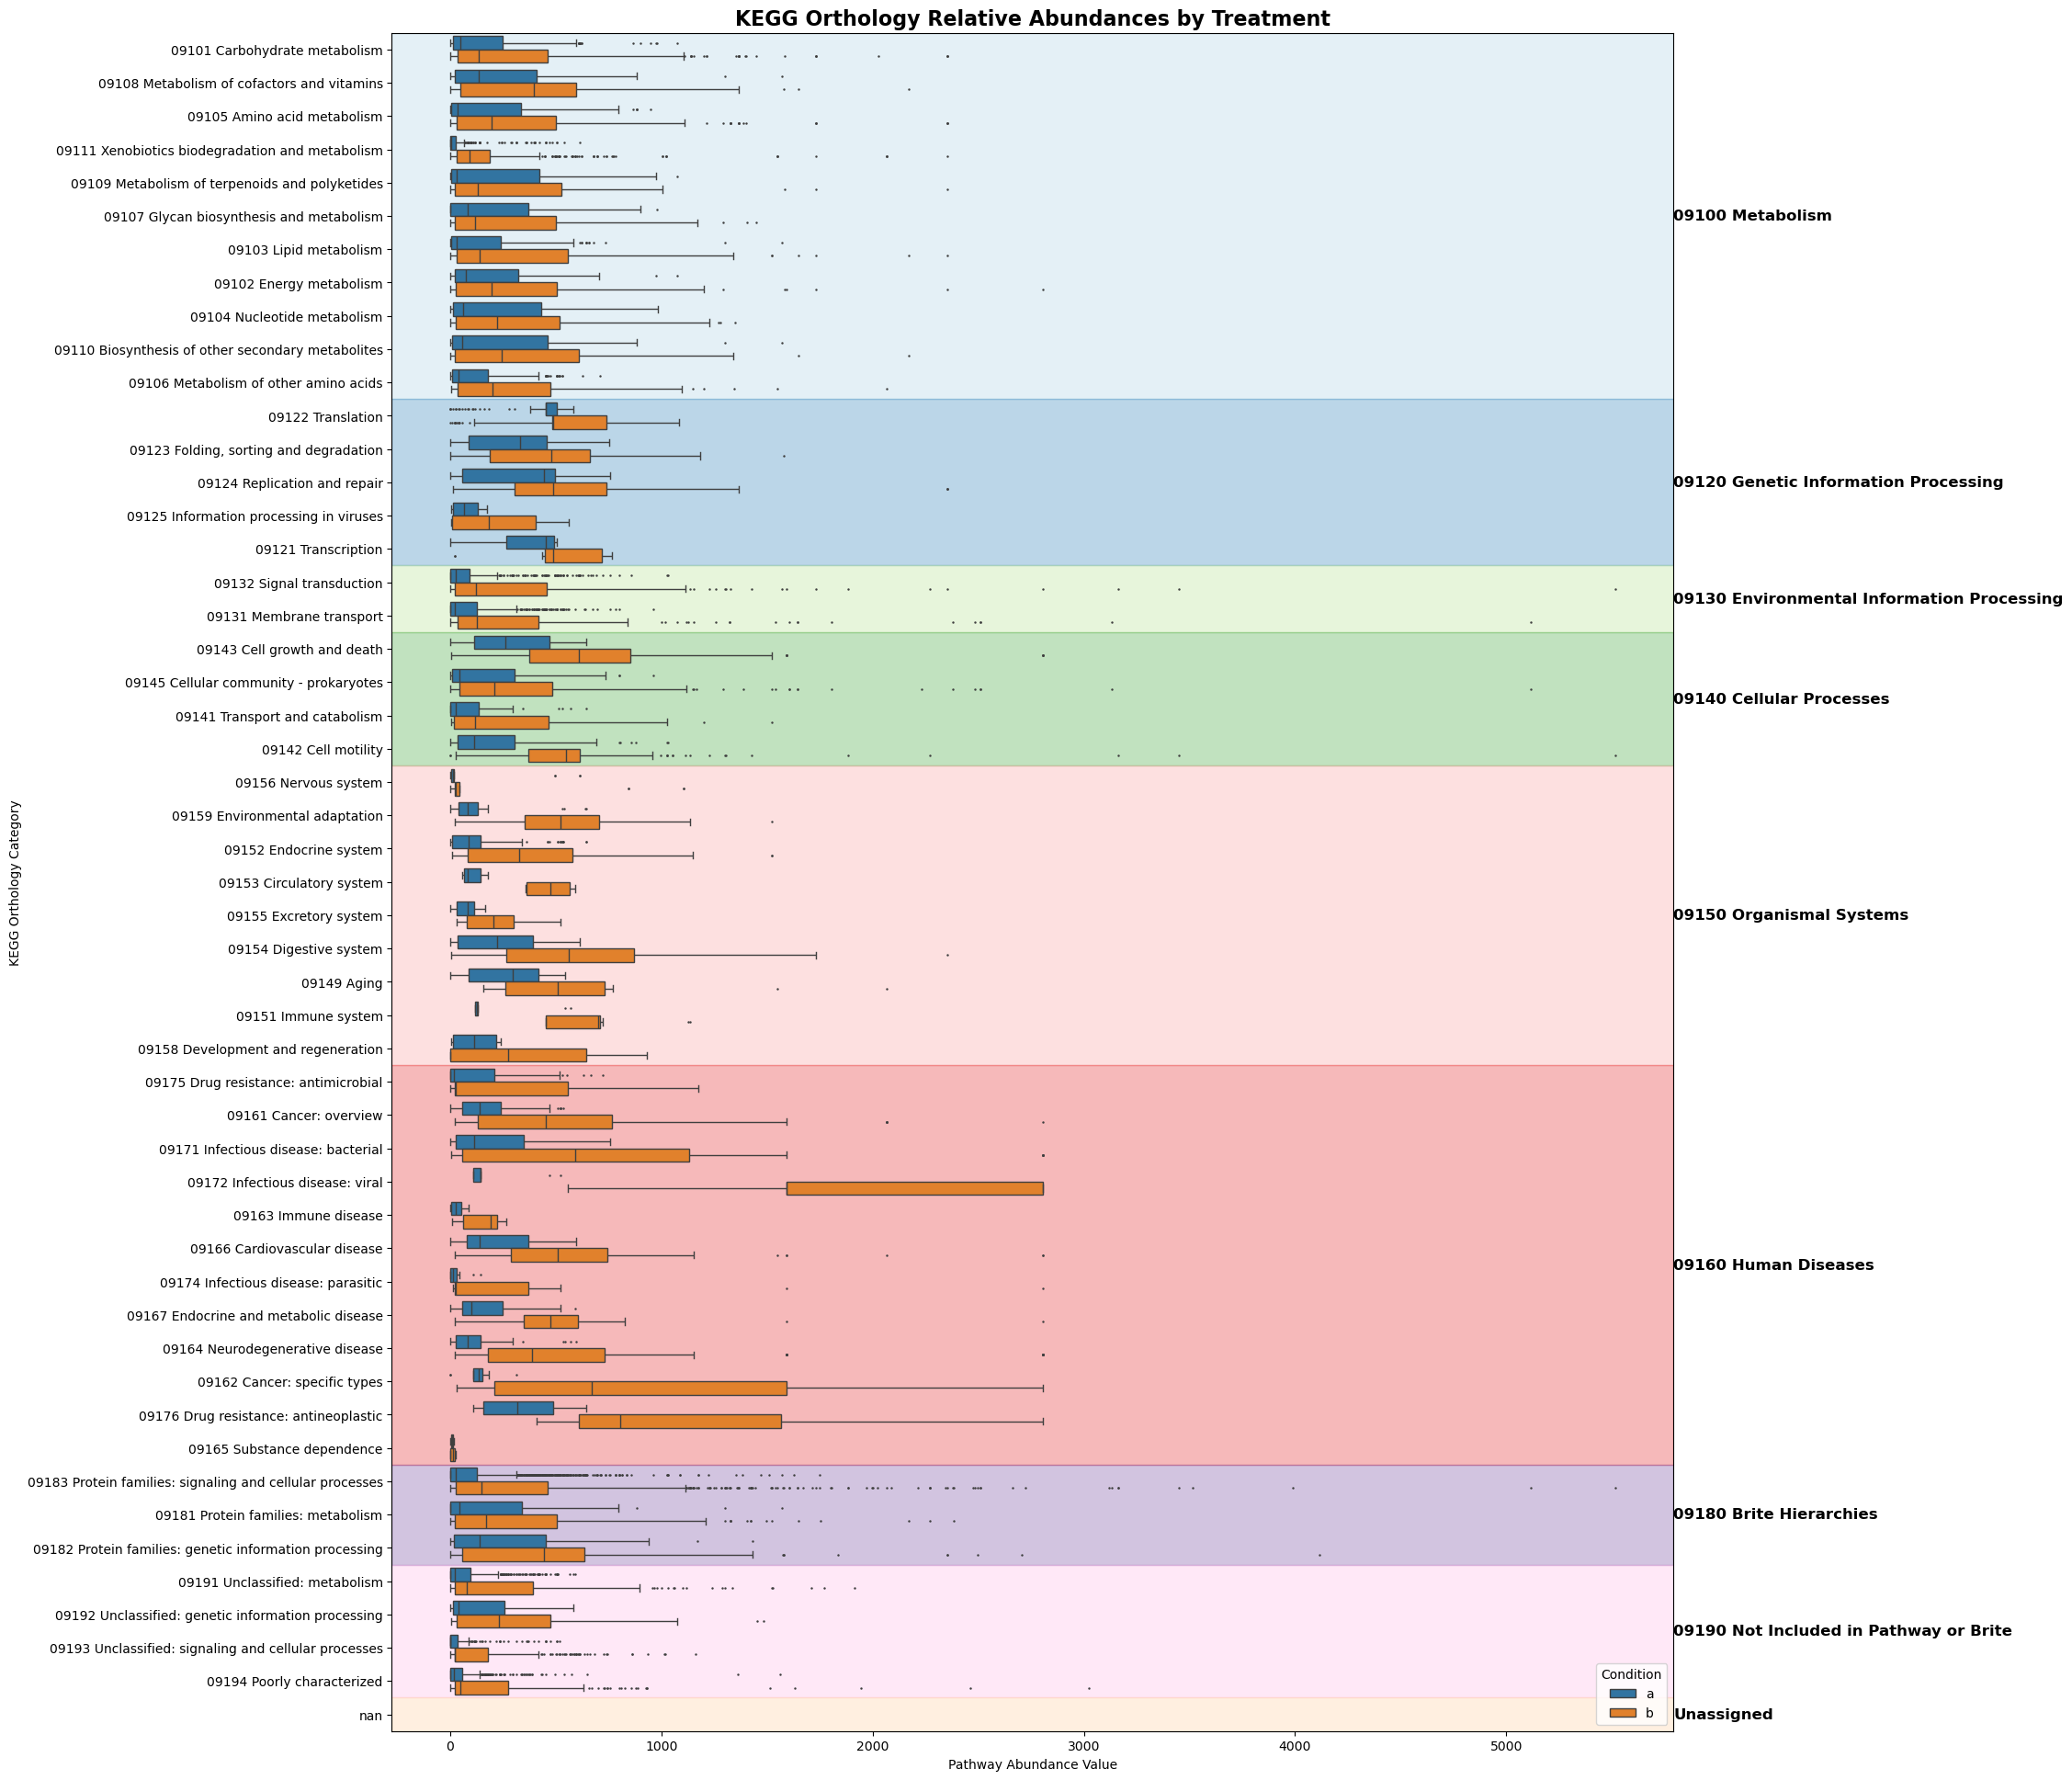

In [15]:
# Create figure
fig, ax = plt.subplots(figsize=(18, 24))

# Remove whitespace in plot
category_positions = range(len(kegg_long['Module'].unique()))
ax.set_ylim(min(category_positions), max(category_positions))

# Plot the boxplot (Horizontal boxplot)
sns.boxplot(x="Abundance",
            y="Module", 
            hue="treatment1", 
            data=kegg_long, 
            order=y_order,
            flierprops=dict(marker='o', markerfacecolor='black', markersize=0.75),
            ax=ax
           )

# Add background colors for each module (shade horizontal regions along y-axis)
for i, (group, (y_start, y_end), color) in enumerate(zip(group_labels, group_bounds, group_colors)):
    ax.axhspan(y_start - 0.5, y_end - 0.5, color=color, alpha=0.3, zorder=0)  # Background color
    ax.text(ax.get_xlim()[1], (y_start + y_end) / 2 - 0.5, group, 
            ha='left', va='center', fontsize=12, fontweight='bold')

# Title and labels
plt.title('KEGG Orthology Relative Abundances by Treatment', fontsize=16, fontweight='bold')
plt.xlabel('Pathway Abundance Value')
plt.ylabel('KEGG Orthology Category')
plt.legend(title='Condition', loc='lower right')

# Save plot
plt.savefig("results/picrust/picrust_kegg.pdf")
plt.show()

#### To do:
- Some entries (K###) have NA modules/categories
- Plot saving cropped
- space between right y axis and labels


### Enzyme Commission Functional Analysis

In [18]:
# Load Data
meta = pd.read_csv(f"../input/{dir}/Metadata.tsv", sep="\t")
ec = pd.read_csv(f"../input/{dir}/picrust/{ec_filename}", sep="\t", header=0)

In [21]:
# Load EC transcoding file
class_mapping = []
subclass_mapping = []

with open("../input/general/enzclass.txt", "r") as f:
    for line in f:
        line = line.strip()

        # Match enzyme classes (e.g., "1. -.-  Oxidoreductases.")
        match_class = re.match(r"^(\d+)\.\s+-\.\s+-\.-\s+(.*)", line)

        # Match enzyme subclasses (e.g., "1. 1. -.-  Acting on the CH-OH group of donors.")
        match_subclass = re.match(r"^(\d+)\.\s*(\d+)\.\s+-\.-\s+(.*)", line)

        if match_class:
            class_mapping.append([match_class.group(1), match_class.group(2)])

        if match_subclass:
            subclass_code = f"{match_subclass.group(1)}.{match_subclass.group(2)}"
            subclass_mapping.append([subclass_code, match_subclass.group(3)])

# Convert to DataFrames
class_df = pd.DataFrame(class_mapping, columns=["class", "class_name"])
subclass_df = pd.DataFrame(subclass_mapping, columns=["subclass", "subclass_name"])

In [22]:
subclass_df

,subclass,subclass_name
0,1.1,Acting on the CH-OH group of donors.
1,1.2,Acting on the aldehyde or oxo group of donors.
2,1.3,Acting on the CH-CH group of donors.
3,1.4,Acting on the CH-NH2 group of donors.
4,1.5,Acting on the CH-NH group of donors.
...,...,...
74,7.2,Catalysing the translocation of inorganic cati...
75,7.3,Catalysing the translocation of inorganic anio...
76,7.4,Catalysing the translocation amino acids and p...
77,7.5,Catalysing the translocation carbohydrates and...


In [23]:
class_df

,class,class_name
0,1,Oxidoreductases.
1,2,Transferases.
2,3,Hydrolases.
3,4,Lyases.
4,5,Isomerases.
5,6,Ligases.
6,7,Translocases.


In [24]:
ec.dtypes

function        object
description     object
sampleID_1     float64
sampleID_1a    float64
sampleID_2     float64
sampleID_2a    float64
dtype: object

In [25]:
# Add class and subclass
ec["class"] = ec["function"].str.extract(r"EC:(\d)\.\d")
ec["subclass"] = ec["function"].str.extract(r"EC:(\d\.\d)\..")
ec

,function,description,sampleID_1,sampleID_1a,sampleID_2,sampleID_2a,class,subclass
0,EC:1.1.1.1,Alcohol dehydrogenase,645.4,402.8,874.24,457.92,1,1.1
1,EC:1.1.1.100,3-oxoacyl-[acyl-carrier-protein] reductase,1650.0,1301.0,2171.84,1572.32,1,1.1
2,EC:1.1.1.108,Carnitine 3-dehydrogenase,21.2,2.4,11.20,12.80,1,1.1
3,EC:1.1.1.11,D-arabinitol 4-dehydrogenase,81.0,0.0,99.00,0.00,1,1.1
4,EC:1.1.1.132,GDP-mannose 6-dehydrogenase,21.2,2.4,11.20,12.80,1,1.1
...,...,...,...,...,...,...,...,...
1307,EC:6.5.1.4,RNA 3'-terminal-phosphate cyclase (ATP),29.2,29.4,22.20,42.80,6,6.5
1308,EC:6.5.1.6,DNA ligase (ATP or NAD(+)),299.0,17.0,501.00,24.00,6,6.5
1309,EC:6.5.1.7,"DNA ligase (ATP, ADP or GTP)",299.0,17.0,501.00,24.00,6,6.5
1310,EC:6.6.1.1,Magnesium chelatase,26.2,2.4,24.20,12.80,6,6.6


In [26]:
# Add class and subclass names
ec = ec.merge(class_df, how="left", on="class")
ec = ec.merge(subclass_df, how="left", on="subclass")
ec

,function,description,sampleID_1,sampleID_1a,sampleID_2,sampleID_2a,class,subclass,class_name,subclass_name
0,EC:1.1.1.1,Alcohol dehydrogenase,645.4,402.8,874.24,457.92,1,1.1,Oxidoreductases.,Acting on the CH-OH group of donors.
1,EC:1.1.1.100,3-oxoacyl-[acyl-carrier-protein] reductase,1650.0,1301.0,2171.84,1572.32,1,1.1,Oxidoreductases.,Acting on the CH-OH group of donors.
2,EC:1.1.1.108,Carnitine 3-dehydrogenase,21.2,2.4,11.20,12.80,1,1.1,Oxidoreductases.,Acting on the CH-OH group of donors.
3,EC:1.1.1.11,D-arabinitol 4-dehydrogenase,81.0,0.0,99.00,0.00,1,1.1,Oxidoreductases.,Acting on the CH-OH group of donors.
4,EC:1.1.1.132,GDP-mannose 6-dehydrogenase,21.2,2.4,11.20,12.80,1,1.1,Oxidoreductases.,Acting on the CH-OH group of donors.
...,...,...,...,...,...,...,...,...,...,...
1307,EC:6.5.1.4,RNA 3'-terminal-phosphate cyclase (ATP),29.2,29.4,22.20,42.80,6,6.5,Ligases.,Forming phosphoric ester bonds.
1308,EC:6.5.1.6,DNA ligase (ATP or NAD(+)),299.0,17.0,501.00,24.00,6,6.5,Ligases.,Forming phosphoric ester bonds.
1309,EC:6.5.1.7,"DNA ligase (ATP, ADP or GTP)",299.0,17.0,501.00,24.00,6,6.5,Ligases.,Forming phosphoric ester bonds.
1310,EC:6.6.1.1,Magnesium chelatase,26.2,2.4,24.20,12.80,6,6.6,Ligases.,Forming nitrogen-metal bonds.


In [27]:
# Summarize by class and subclass
numeric_cols = ec.columns[2:-4]  # define only sample cols
print(numeric_cols)
ec_summarized = ec.groupby(["class", "class_name", "subclass", "subclass_name"])[numeric_cols].sum().reset_index()
ec_summarized

Index(['sampleID_1', 'sampleID_1a', 'sampleID_2', 'sampleID_2a'], dtype='object')


,class,class_name,subclass,subclass_name,sampleID_1,sampleID_1a,sampleID_2,sampleID_2a
0,1,Oxidoreductases.,1.1,Acting on the CH-OH group of donors.,20981.25,11285.0,29349.77,13763.62
1,1,Oxidoreductases.,1.2,Acting on the aldehyde or oxo group of donors.,10738.50,8318.0,15864.96,9738.10
2,1,Oxidoreductases.,1.3,Acting on the CH-CH group of donors.,8920.80,4535.6,13340.67,5260.47
3,1,Oxidoreductases.,1.4,Acting on the CH-NH2 group of donors.,4388.95,3156.4,6335.26,3727.69
4,1,Oxidoreductases.,1.5,Acting on the CH-NH group of donors.,3537.35,1463.2,5168.66,1811.29
5,1,Oxidoreductases.,1.6,Acting on NADH or NADPH.,7593.70,5342.4,11451.50,6097.24
6,1,Oxidoreductases.,1.7,Acting on other nitrogenous compounds as donors.,3598.80,1197.6,5964.31,1287.19
7,1,Oxidoreductases.,1.8,Acting on a sulfur group of donors.,5307.90,2748.8,8102.01,3239.39
8,1,Oxidoreductases.,1.9,Acting on a heme group of donors.,1923.20,384.4,2967.20,444.80
9,2,Transferases.,2.1,Transferring one-carbon groups.,25847.00,17115.0,39333.75,19657.51


In [28]:
# Melt the DataFrame to long format
ec_long = ec_summarized.melt(
    id_vars=["class", "class_name", "subclass", "subclass_name"],
    var_name="sample",
    value_name="abundance"
)
ec_long

,class,class_name,subclass,subclass_name,sample,abundance
0,1,Oxidoreductases.,1.1,Acting on the CH-OH group of donors.,sampleID_1,20981.25
1,1,Oxidoreductases.,1.2,Acting on the aldehyde or oxo group of donors.,sampleID_1,10738.50
2,1,Oxidoreductases.,1.3,Acting on the CH-CH group of donors.,sampleID_1,8920.80
3,1,Oxidoreductases.,1.4,Acting on the CH-NH2 group of donors.,sampleID_1,4388.95
4,1,Oxidoreductases.,1.5,Acting on the CH-NH group of donors.,sampleID_1,3537.35
...,...,...,...,...,...,...
163,6,Ligases.,6.2,Forming carbon-sulfur bonds.,sampleID_2a,2156.95
164,6,Ligases.,6.3,Forming carbon-nitrogen bonds.,sampleID_2a,19974.59
165,6,Ligases.,6.4,Forming carbon-carbon bonds.,sampleID_2a,1652.40
166,6,Ligases.,6.5,Forming phosphoric ester bonds.,sampleID_2a,1206.58


In [29]:
# Add condition/treatment metadata
ec_long_meta = ec_long.merge(meta[["ID","treatment1"]], how="left", left_on="sample", right_on="ID").drop("ID", axis=1)
for colname in ["class_name", "subclass_name"]:
    ec_long_meta[colname] = ec_long_meta[colname].str.replace(".","")
ec_long_meta

,class,class_name,subclass,subclass_name,sample,abundance,treatment1
0,1,Oxidoreductases,1.1,Acting on the CH-OH group of donors,sampleID_1,20981.25,b
1,1,Oxidoreductases,1.2,Acting on the aldehyde or oxo group of donors,sampleID_1,10738.50,b
2,1,Oxidoreductases,1.3,Acting on the CH-CH group of donors,sampleID_1,8920.80,b
3,1,Oxidoreductases,1.4,Acting on the CH-NH2 group of donors,sampleID_1,4388.95,b
4,1,Oxidoreductases,1.5,Acting on the CH-NH group of donors,sampleID_1,3537.35,b
...,...,...,...,...,...,...,...
163,6,Ligases,6.2,Forming carbon-sulfur bonds,sampleID_2a,2156.95,a
164,6,Ligases,6.3,Forming carbon-nitrogen bonds,sampleID_2a,19974.59,a
165,6,Ligases,6.4,Forming carbon-carbon bonds,sampleID_2a,1652.40,a
166,6,Ligases,6.5,Forming phosphoric ester bonds,sampleID_2a,1206.58,a


In [30]:
print("Number of classes:", ec_long_meta["class"].nunique())
print("Number of subclasses:", ec_long_meta["subclass"].nunique())

Number of classes: 6
Number of subclasses: 42


In [31]:
# SETTING UP COLOURS FOR THE BOXPLOT CLASSES

# Get unique groups in the order they appear
group_labels = ec_long_meta["class_name"].unique().tolist()

# Keep only unique (class_name, subclass) pairs
unique_groups = ec_long_meta[["class_name", "subclass"]].drop_duplicates().reset_index()

# Compute bounds
group_bounds = (
    unique_groups.groupby("class_name")["index"]
    .apply(lambda x: (x.min(), x.max() + 1))
    .tolist()
)

group_colors = ['#A6CEE3', '#1F78B4', '#B2DF8A', '#33A02C', '#FB9A99', '#E31A1C']  # Soft pastel colors

print("Group Labels:", group_labels)
print("Group Bounds:", group_bounds)
print("Group Colours:", group_colors)

Group Labels: ['Oxidoreductases', 'Transferases', 'Hydrolases', 'Lyases', 'Isomerases', 'Ligases']
Group Bounds: [(np.int64(18), np.int64(26)), (np.int64(31), np.int64(36)), (np.int64(36), np.int64(42)), (np.int64(26), np.int64(31)), (np.int64(0), np.int64(9)), (np.int64(9), np.int64(18))]
Group Colours: ['#A6CEE3', '#1F78B4', '#B2DF8A', '#33A02C', '#FB9A99', '#E31A1C']


In [32]:
y_order = unique_groups["class_name"].unique() # not used, just in case

In [33]:
ec_long_meta

,class,class_name,subclass,subclass_name,sample,abundance,treatment1
0,1,Oxidoreductases,1.1,Acting on the CH-OH group of donors,sampleID_1,20981.25,b
1,1,Oxidoreductases,1.2,Acting on the aldehyde or oxo group of donors,sampleID_1,10738.50,b
2,1,Oxidoreductases,1.3,Acting on the CH-CH group of donors,sampleID_1,8920.80,b
3,1,Oxidoreductases,1.4,Acting on the CH-NH2 group of donors,sampleID_1,4388.95,b
4,1,Oxidoreductases,1.5,Acting on the CH-NH group of donors,sampleID_1,3537.35,b
...,...,...,...,...,...,...,...
163,6,Ligases,6.2,Forming carbon-sulfur bonds,sampleID_2a,2156.95,a
164,6,Ligases,6.3,Forming carbon-nitrogen bonds,sampleID_2a,19974.59,a
165,6,Ligases,6.4,Forming carbon-carbon bonds,sampleID_2a,1652.40,a
166,6,Ligases,6.5,Forming phosphoric ester bonds,sampleID_2a,1206.58,a


FileNotFoundError: [Errno 2] No such file or directory: 'results/picrust/picrust_ec.pdf'

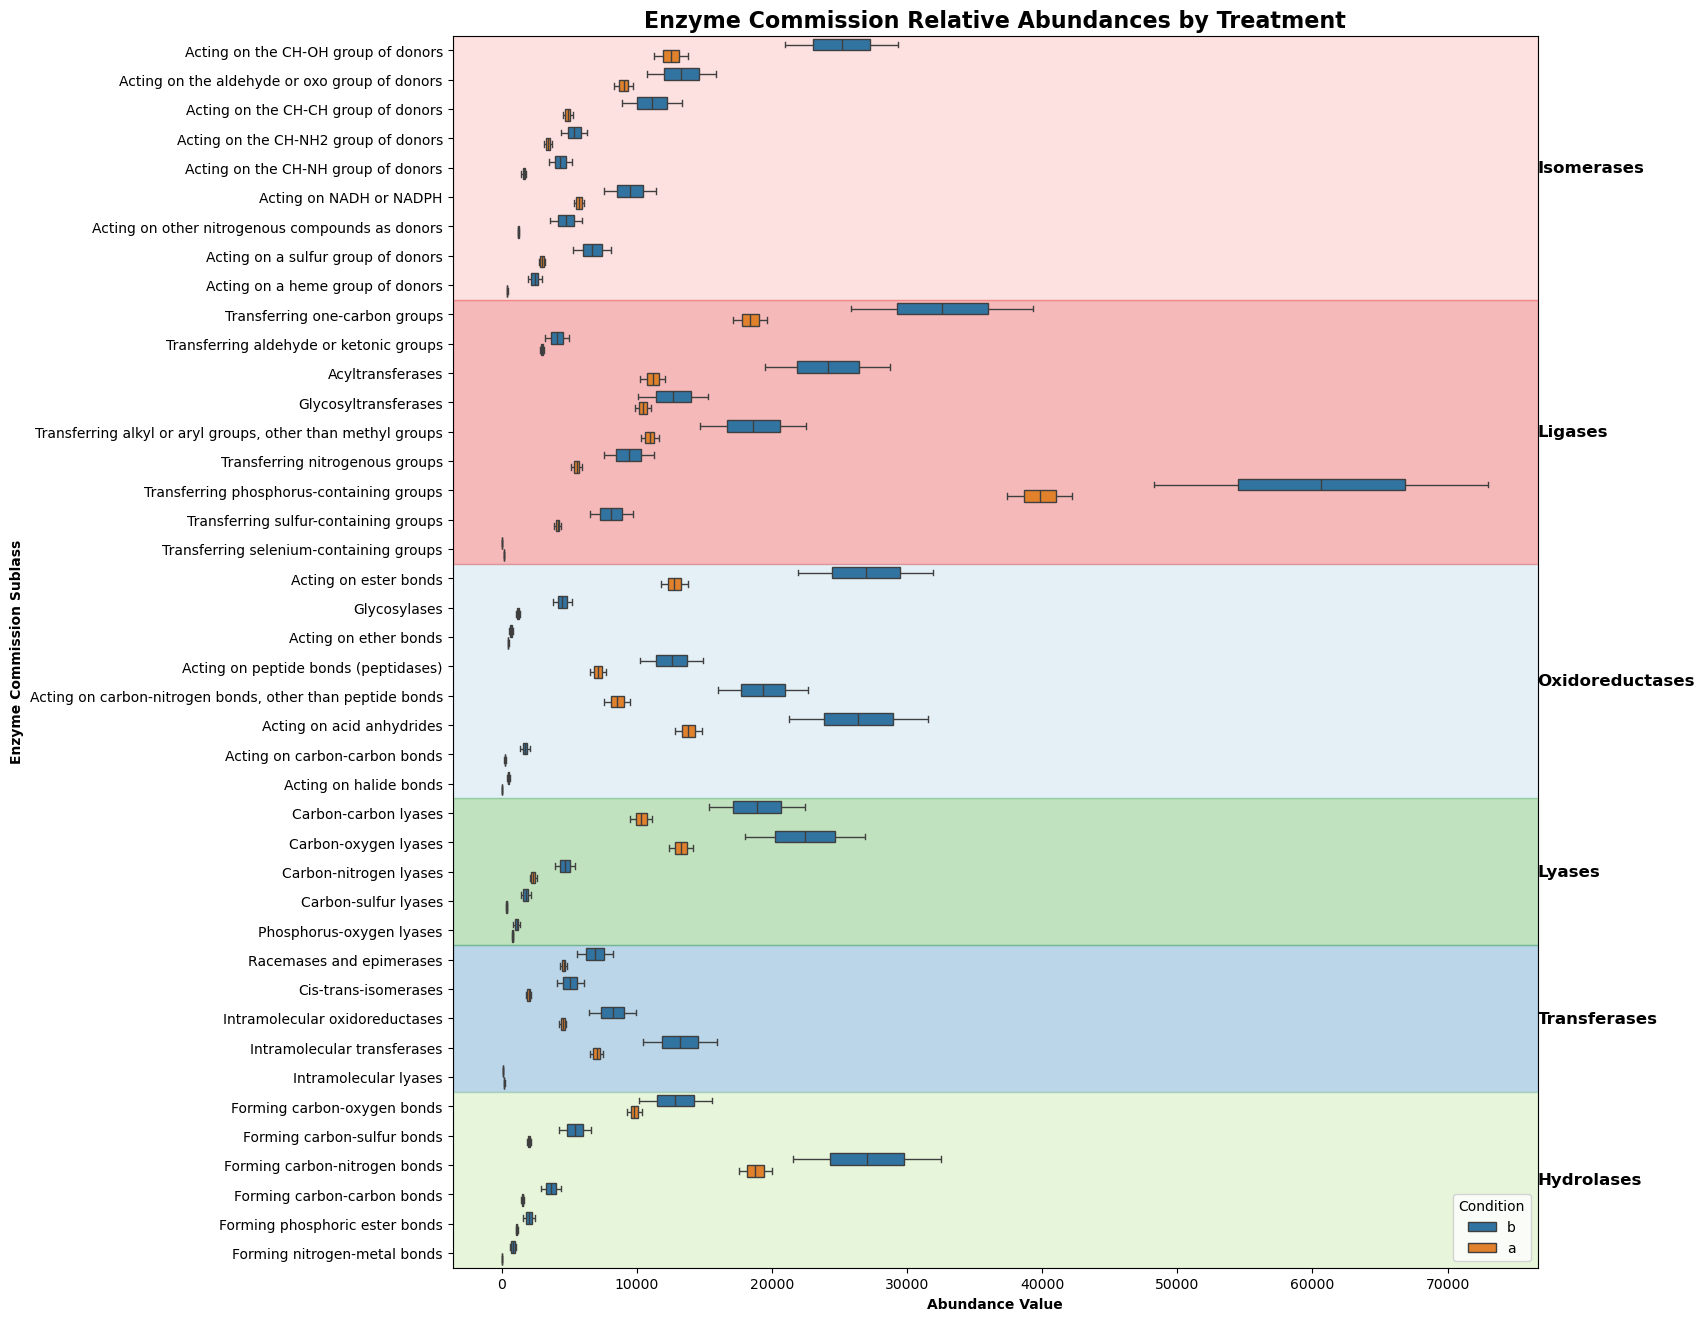

In [34]:
# Create figure
fig,ax = plt.subplots(figsize=(14, 16))

# Remove whitespace in plot
category_positions = range(len(ec_long_meta['class'].unique()))
ax.set_ylim(min(category_positions), max(category_positions))

# Seaborn boxplot
sns.boxplot(x="abundance",
            y="subclass_name", 
            hue="treatment1", 
            data=ec_long_meta, 
            flierprops=dict(marker='o', markerfacecolor='black', markersize=0.75),
            ax=ax
           )

# Add background colors for each module (shade horizontal regions along y-axis)
for i, (group, (y_start, y_end), color) in enumerate(zip(group_labels, group_bounds, group_colors)):
    ax.axhspan(y_start - 0.5, y_end - 0.5, color=color, alpha=0.3, zorder=0)  # Background color
    ax.text(ax.get_xlim()[1], (y_start + y_end) / 2 - 0.5, group, 
            ha='left', va='center', fontsize=12, fontweight='bold')

# Title and labels
plt.title('Enzyme Commission Relative Abundances by Treatment', fontsize=16, fontweight='bold')
plt.xlabel('Abundance Value', fontweight='bold')
plt.ylabel('Enzyme Commission Sublass', fontweight='bold')
plt.legend(title='Condition', loc='lower right')

# Save plot
plt.savefig("results/picrust/picrust_ec.pdf")
plt.show()

#### To do:
- Order subgroups within groups by abundance

### MetaCyc Pathway Analysis
On hold as MetaCyc groups require license to be accessed

In [ ]:
# Load Data
meta = pd.read_csv(f"{cwd}/input/{dir}/Metadata.tsv", sep="\t")
metacyc = pd.read_csv(f"{cwd}/input/{dir}/picrust/{metacyc_filename}", sep="\t", header=0)

In [ ]:
meta

,ID,treatment1,bad3,bad4,bad5,num6,num7,mix8,bad9,badpairwise10,materialSampleID,target_gene
0,sampleID_1,b,a,a,NaN,1,NaN,2,a,NaN,ERS3508481,SSU rRNA
1,sampleID_2,b,a,NaN,NaN,2,1.0,2,b,2,ERS3508482,SSU rRNA
2,sampleID_1a,a,a,NaN,NaN,3,NaN,a,c,2,ERS3508483,SSU rRNA
3,sampleID_2a,a,a,a,NaN,1,NaN,a,d,a,ERS3508484,SSU rRNA


In [ ]:
metacyc["pathway"].unique()

array(['1CMET2-PWY', '3-HYDROXYPHENYLACETATE-DEGRADATION-PWY',
       'ANAEROFRUCAT-PWY', 'ANAGLYCOLYSIS-PWY', 'ARG+POLYAMINE-SYN',
       'ARGORNPROST-PWY', 'ARGSYN-PWY', 'ARGSYNBSUB-PWY', 'ARO-PWY',
       'ASPASN-PWY', 'AST-PWY', 'BIOTIN-BIOSYNTHESIS-PWY',
       'BRANCHED-CHAIN-AA-SYN-PWY', 'CALVIN-PWY',
       'CATECHOL-ORTHO-CLEAVAGE-PWY', 'COA-PWY', 'COBALSYN-PWY',
       'CODH-PWY', 'COLANSYN-PWY', 'COMPLETE-ARO-PWY', 'CRNFORCAT-PWY',
       'DAPLYSINESYN-PWY', 'DENITRIFICATION-PWY', 'DENOVOPURINE2-PWY',
       'DHGLUCONATE-PYR-CAT-PWY', 'DTDPRHAMSYN-PWY', 'FAO-PWY',
       'FASYN-ELONG-PWY', 'FASYN-INITIAL-PWY', 'FERMENTATION-PWY',
       'FOLSYN-PWY', 'GALLATE-DEGRADATION-I-PWY', 'GLUCONEO-PWY',
       'GLUCOSE1PMETAB-PWY', 'GLUTORN-PWY', 'GLYCOCAT-PWY',
       'GLYCOGENSYNTH-PWY', 'GLYCOLYSIS', 'GLYCOLYSIS-E-D',
       'GLYCOLYSIS-TCA-GLYOX-BYPASS', 'GLYOXYLATE-BYPASS',
       'HEME-BIOSYNTHESIS-II', 'HEMESYN2-PWY', 'HISDEG-PWY',
       'HISTSYN-PWY', 'HOMOSER-METSYN-PWY', '

In [ ]:
metacyc["description"].unique()

array(['N10-formyl-tetrahydrofolate biosynthesis',
       '4-hydroxyphenylacetate degradation', 'homolactic fermentation',
       'glycolysis III (from glucose)',
       'superpathway of arginine and polyamine biosynthesis',
       'arginine, ornithine and proline interconversion',
       'L-arginine biosynthesis I (via L-ornithine)',
       'L-arginine biosynthesis II (acetyl cycle)',
       'chorismate biosynthesis I',
       'superpathway of L-aspartate and L-asparagine biosynthesis',
       'L-arginine degradation II (AST pathway)', 'biotin biosynthesis I',
       'superpathway of branched amino acid biosynthesis',
       'Calvin-Benson-Bassham cycle',
       'catechol degradation to &beta;-ketoadipate',
       'coenzyme A biosynthesis I',
       'adenosylcobalamin salvage from cobinamide I',
       'reductive acetyl coenzyme A pathway',
       'colanic acid building blocks biosynthesis',
       'superpathway of aromatic amino acid biosynthesis',
       'creatinine degradation I', 

In [ ]:
# Melt the DataFrame to long format
metacyc_long = metacyc.melt(
    id_vars=["pathway", "description"],
    var_name="sample",
    value_name="abundance"
)
metacyc_long

,pathway,description,sample,abundance
0,1CMET2-PWY,N10-formyl-tetrahydrofolate biosynthesis,sampleID_1,480.810875
1,3-HYDROXYPHENYLACETATE-DEGRADATION-PWY,4-hydroxyphenylacetate degradation,sampleID_1,82.584877
2,ANAEROFRUCAT-PWY,homolactic fermentation,sampleID_1,406.358313
3,ANAGLYCOLYSIS-PWY,glycolysis III (from glucose),sampleID_1,494.467916
4,ARG+POLYAMINE-SYN,superpathway of arginine and polyamine biosynt...,sampleID_1,113.672819
...,...,...,...,...
1003,TRPSYN-PWY,L-tryptophan biosynthesis,sampleID_2a,541.116259
1004,TYRFUMCAT-PWY,L-tyrosine degradation I,sampleID_2a,48.699543
1005,UBISYN-PWY,superpathway of ubiquinol-8 biosynthesis (prok...,sampleID_2a,226.302670
1006,UDPNAGSYN-PWY,UDP-N-acetyl-D-glucosamine biosynthesis I,sampleID_2a,516.193182
